# Emotion Model
## Explore the Data

In [2]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

image_size=(48,48)
 
def load_face_data():
    data = pd.read_csv("../data/face_data/fer2013/fer2013.csv")
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    
    return x
 
faces, emotions = load_face_data()
faces = preprocess_input(faces)
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2,shuffle=True)

/Users/camesmith/miniconda/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


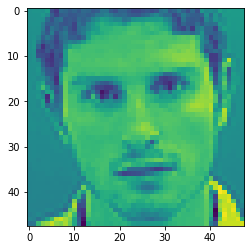

In [7]:
# Check that the data looks correct.
import matplotlib.pyplot as plt
plt.imshow(X_train[1005].reshape(48, 48))

## Modeling
Below I use `tensorflow.keras` to implement [this paper](https://arxiv.org/pdf/1710.07557.pdf). I use the Keras functional mode because the model uses residual modules -- a sequential model can't do this!

The architecture involves a "base module" of two conv2d/batchnorm layers followed by four Xception-esque modules (explained below) and a module of conv2d and global average pooling/2d. The output is a softmax. The Xception modules have two parallel components: 2x sep-conv2d/batchnorm -> maxpool2d and a conv2d/batchnorm which are summed together (see _figure 3_ in the paper).

Although I've defined the model in a notebook, I copied this code to a python module and ran it on a cluster. A `g3.8xlarge` instance on AWS took approximately 1.5 days to run this model.

In [3]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Activation,
    Convolution2D,
    Conv2D,
    Dropout,
    AveragePooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
    SeparableConv2D,
    Flatten
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [4]:
# Model hyper-parameters.
batch_size = 32
num_epochs = 100
input_shape = (48, 48, 1)
num_classes = 7
regularization = l2(0.01)

# Data generator to create additional image data.
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

##### Define the model #####
# Base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# Module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# Module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



# Define callbacks.
patience = 50
csv_logger = CSVLogger("models/emotion_training_log.log", append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
model_checkpoint = ModelCheckpoint("models/emotion_detection_v2/my_XCEPTION.{epoch:02d}-{val_acc:.2f}.model",
                                   "val_loss", verbose=1, save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
 
model.fit_generator(data_generator.flow(X_train, y_train, batch_size),
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_test, y_test))

W0901 22:01:28.050146 4433044928 deprecation.py:506] From /Users/camesmith/miniconda/envs/deep_learning/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
from tensorflow.keras.models import load_model

In [12]:
model = load_model("../models/emotion_detection_v2/my_XCEPTION.72-0.64.model")

In [14]:
model.evaluate(X_test, y_test)

7178/7178 [==============================] - 8s 1ms/sample - loss: 0.8227 - acc: 0.6984


[0.8226781053176395, 0.6983839]